# 2010-2020 Nort Atlantic / Gulf Stream Argo sampling

https://github.com/orgs/euroargodev/projects/7#card-81467052

- Extract 2010-2020 deployment plan
- Extract initial state on 2010-01-01
- Compute effective 2010-2020 sampling

https://regionmask.readthedocs.io/en/stable/

In [26]:
import regionmask

import numpy as np
import pandas as pd
import xarray as xr
from xhistogram.xarray import histogram

import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

import argopy
from argopy import IndexFetcher as ArgoIndexFetcher
from argopy.options import OPTIONS
argopy.set_options(local_ftp="/Volumes/CORIOLIS-GDAC")
argopy.status()

HTML(value='<table><tr><td><img src="https://img.shields.io/static/v1?style=flat-square&label=src%20argovis%20…

In [2]:
argopy.clear_cache()

# Set-up

## Define regions

In [3]:
# Create the list of regionmask.Regions:

def rect_box(SW, NE):
    # SW: lon_south_west, lat_south_west
    # NE: lon_north_east, lat_north_east
    return [[SW[0],SW[1]],[NE[0],SW[1]],[NE[0],NE[1]],[SW[0],NE[1]]]

dict_regions = {
    'NATL': {'box': [-80,0.,15,65, '2010-01-01', '2020-01-01'], 'name': 'North Atlantic'},
    'GSE tight': {'box': [-75.,-48.,33,45.5, '2010-01-01', '2020-01-01'], 'name': 'Gulf Stream Extension'},
    # 'GSE': {'box': [-75.,-35.,35,50.], 'name': 'Gulf Stream Extension'},
}

boxes, numbers, names, abbrevs = [], [], [], []
for ii, r in enumerate(dict_regions.items()):
    numbers.append(ii)
    names.append(r[1]['name'])
    abbrevs.append(r[0])
    boxes.append(rect_box([r[1]['box'][0],r[1]['box'][2]],[r[1]['box'][1],r[1]['box'][3]]))
regions = regionmask.Regions(boxes, numbers, names, abbrevs, name='BCmask')
regions

<regionmask.Regions>
Name:     BCmask
overlap:  False

Regions:
0      NATL        North Atlantic
1 GSE tight Gulf Stream Extension

[2 regions]

<GeoAxesSubplot:>

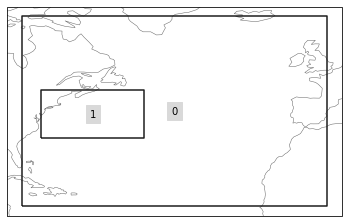

In [4]:
regions.plot()

## Load index for each regions

In [5]:
for r in regions:
    print(r.abbrev)
    index_box = dict_regions[r.abbrev]['box']
    # argo = ArgoIndexFetcher(src='gdac', ftp=OPTIONS['local_ftp'], cache=True).region(index_box)
    argo = ArgoIndexFetcher(src='gdac', cache=True).region(index_box)
    dict_regions[r.abbrev]['fetcher'] = argo
    dict_regions[r.abbrev]['index'] = argo.index
    # Add cycle number to each profiles:
    dict_regions[r.abbrev]['index']['cycle_number'] = dict_regions[r.abbrev]['index'].apply(lambda x: int("".join([c for c in x['file'].split("/")[-1].split("_")[-1].split(".nc")[0] if c.isdigit()])), axis=1)
    # Add profile direction:
    dict_regions[r.abbrev]['index']['direction'] = dict_regions[r.abbrev]['index'].apply(lambda x: 'D' if 'D' in x['file'].split("/")[-1].split("_")[-1].split(".nc")[0] else 'A', axis=1)

NATL
GSE tight


# Get deployment plan from index


For floats with a cycle number "0" we select the ascending profile even for floats with a descending profile ...


For floats without a cycle number "0", we select the cycle number "1" (and again, only ascending profiles)



In [8]:
df0 = dict_regions['NATL']['index'][dict_regions['NATL']['index']['cycle_number'] == 0].reset_index()
df0 = df0[df0['direction'] == 'A'].reset_index(drop=True)
unique_wmo0 = np.unique(df0['wmo'])
df0

,index,file,date,latitude,longitude,ocean,profiler_code,institution_code,date_update,wmo,institution,profiler,cycle_number,direction
0,2499,aoml/1901457/profiles/D1901457_000.nc,2010-05-11 12:03:40,20.036,-22.992,A,851,AO,2019-09-03 12:23:28,1901457,"AOML, USA","Solo, Seabird conductivity sensor",0,A
1,2740,aoml/1901459/profiles/D1901459_000.nc,2010-05-14 03:53:20,20.122,-34.544,A,851,AO,2019-06-11 09:06:06,1901459,"AOML, USA","Solo, Seabird conductivity sensor",0,A
2,2995,aoml/1901460/profiles/D1901460_000.nc,2010-05-15 05:57:38,20.041,-37.926,A,851,AO,2019-06-11 09:20:43,1901460,"AOML, USA","Solo, Seabird conductivity sensor",0,A
3,3227,aoml/1901461/profiles/D1901461_000.nc,2010-05-18 05:57:34,25.244,-49.994,A,851,AO,2019-06-11 11:42:06,1901461,"AOML, USA","Solo, Seabird conductivity sensor",0,A
4,3483,aoml/1901463/profiles/D1901463_000.nc,2010-05-17 03:18:46,23.789,-46.011,A,851,AO,2019-06-12 08:30:21,1901463,"AOML, USA","Solo, Seabird conductivity sensor",0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,170944,meds/4902455/profiles/R4902455_000.nc,2018-10-04 03:53:00,43.726,-55.907,A,865,ME,2018-10-04 11:15:41,4902455,"MEDS, Canada",Nova float,0,A
305,170990,meds/4902456/profiles/D4902456_000.nc,2018-10-04 11:16:00,43.441,-55.851,A,865,ME,2020-10-20 22:08:18,4902456,"MEDS, Canada",Nova float,0,A
306,171036,meds/4902457/profiles/D4902457_000.nc,2018-11-20 01:14:00,42.096,-49.308,A,865,ME,2020-10-21 14:47:12,4902457,"MEDS, Canada",Nova float,0,A
307,171061,meds/4902458/profiles/D4902458_000.nc,2018-11-20 06:36:00,41.758,-48.893,A,865,ME,2020-10-20 22:22:39,4902458,"MEDS, Canada",Nova float,0,A


In [9]:
df1 = dict_regions['NATL']['index'][dict_regions['NATL']['index']['cycle_number'] == 1].reset_index()
df1 = df1[df1['direction'] == 'A'].reset_index(drop=True)
df1 = df1[df1.apply(lambda x: x['wmo'] not in unique_wmo0, axis=1)].reset_index(drop=True)
df1

,index,file,date,latitude,longitude,ocean,profiler_code,institution_code,date_update,wmo,institution,profiler,cycle_number,direction
0,7483,aoml/2901434/profiles/R2901434_001.nc,2012-05-08 10:26:48,36.047,-7.766,A,846,AO,2018-10-23 22:53:28,2901434,"AOML, USA","Webb Research, Seabird sensor",1,A
1,7541,aoml/2901435/profiles/R2901435_001.nc,2012-05-09 04:19:03,38.669,-10.281,A,846,AO,2018-10-23 22:53:46,2901435,"AOML, USA","Webb Research, Seabird sensor",1,A
2,16332,aoml/4901213/profiles/D4901213_001.nc,2010-10-02 10:11:29,16.964,-37.420,A,851,AO,2019-09-04 08:21:11,4901213,"AOML, USA","Solo, Seabird conductivity sensor",1,A
3,17219,aoml/4901217/profiles/D4901217_001.nc,2010-12-11 09:37:30,35.647,-50.786,A,851,AO,2022-01-10 15:11:10,4901217,"AOML, USA","Solo, Seabird conductivity sensor",1,A
4,17446,aoml/4901218/profiles/D4901218_001.nc,2010-12-14 10:31:26,34.497,-71.292,A,851,AO,2019-09-04 10:03:23,4901218,"AOML, USA","Solo, Seabird conductivity sensor",1,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758,171345,meds/4902495/profiles/D4902495_001.nc,2019-09-17 04:37:00,57.121,-49.467,A,844,ME,2021-11-22 17:36:15,4902495,"MEDS, Canada","Arvor, Seabird conductivity sensor",1,A
759,171356,meds/4902496/profiles/R4902496_001.nc,2019-11-30 05:09:00,46.990,-43.064,A,844,ME,2019-12-02 13:15:36,4902496,"MEDS, Canada","Arvor, Seabird conductivity sensor",1,A
760,171360,meds/4902497/profiles/D4902497_001.nc,2019-11-30 05:14:00,46.996,-43.062,A,844,ME,2021-07-23 13:09:04,4902497,"MEDS, Canada","Arvor, Seabird conductivity sensor",1,A
761,171364,meds/4902498/profiles/D4902498_001.nc,2019-12-02 04:55:00,42.210,-48.366,A,844,ME,2021-11-19 15:43:31,4902498,"MEDS, Canada","Arvor, Seabird conductivity sensor",1,A


In [10]:
Nt = len(np.unique(dict_regions['NATL']['index']['wmo']))
unique_wmo1 = np.unique(df1['wmo'])
Nd = len(unique_wmo0) + len(unique_wmo1)
print("%i floats reporting any cycle in the area" % Nt)
print("%i floats deployed in the area and time period (reporting cycle #0)" % len(unique_wmo0))
print("%i floats certainly deployed in the area  and time period (reporting cycle #1)" % len(unique_wmo1))
print("%i floats assumed to be deployed in the area and time period (%0.1f %%)" % (Nd, Nd*100/Nt))
print("%i floats NOT deployed in the area OR during the time period (%0.1f %%)" % (Nt - Nd, 100-Nd*100/Nt))

1586 floats reporting any cycle in the area
309 floats deployed in the area and time period (reporting cycle #0)
763 floats certainly deployed in the area  and time period (reporting cycle #1)
1072 floats assumed to be deployed in the area and time period (67.6 %)
514 floats NOT deployed in the area OR during the time period (32.4 %)


In [11]:
# dict_regions['NATL']['deployment'] = df0.reset_index(drop=True)
dict_regions['NATL']['deployment'] = pd.concat([df0, df1]).sort_values(by='date').reset_index(drop=True)
dict_regions['NATL']['deployment']

,index,file,date,latitude,longitude,ocean,profiler_code,institution_code,date_update,wmo,institution,profiler,cycle_number,direction
0,73009,bodc/6900656/profiles/D6900656_001.nc,2010-02-12 11:47:13,55.307,-15.886,A,846,BO,2019-09-12 21:32:40,6900656,"BODC, United Kingdom","Webb Research, Seabird sensor",1,A
1,73112,bodc/6900657/profiles/D6900657_001.nc,2010-02-14 02:02:55,53.579,-16.017,A,846,BO,2016-10-12 02:18:23,6900657,"BODC, United Kingdom","Webb Research, Seabird sensor",1,A
2,72871,bodc/6900655/profiles/D6900655_001.nc,2010-02-23 07:02:57,51.158,-12.241,A,846,BO,2016-10-12 01:46:13,6900655,"BODC, United Kingdom","Webb Research, Seabird sensor",1,A
3,159849,meds/4901139/profiles/D4901139_001.nc,2010-04-20 18:58:00,43.891,-57.824,A,846,ME,2017-02-28 16:28:53,4901139,"MEDS, Canada","Webb Research, Seabird sensor",1,A
4,161044,meds/4901155/profiles/R4901155_001.nc,2010-04-20 23:56:00,43.528,-57.508,A,846,ME,2018-02-20 14:53:43,4901155,"MEDS, Canada","Webb Research, Seabird sensor",1,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1067,155612,coriolis/7900561/profiles/D7900561_001.nc,2019-12-01 10:18:02,17.796,-20.612,A,846,IF,2021-03-24 10:41:50,7900561,"Ifremer, France","Webb Research, Seabird sensor",1,A
1068,155592,coriolis/7900560/profiles/D7900560_001.nc,2019-12-01 10:58:14,17.790,-20.610,A,846,IF,2021-02-19 14:08:07,7900560,"Ifremer, France","Webb Research, Seabird sensor",1,A
1069,171367,meds/4902499/profiles/D4902499_001.nc,2019-12-02 04:55:00,42.173,-48.324,A,844,ME,2021-11-16 19:47:11,4902499,"MEDS, Canada","Arvor, Seabird conductivity sensor",1,A
1070,171364,meds/4902498/profiles/D4902498_001.nc,2019-12-02 04:55:00,42.210,-48.366,A,844,ME,2021-11-19 15:43:31,4902498,"MEDS, Canada","Arvor, Seabird conductivity sensor",1,A


## Analyse the deployment plan

In [12]:
text_kws = dict(
    bbox=dict(color="none"),
    path_effects=[pe.withStroke(linewidth=2, foreground="w")],
    color="#67000d",
    fontsize=10,
)
subplot_kw={'projection': argopy.plot.utils.cartopy.crs.PlateCarree(), 'extent': np.array([-85,5.,10,60]) + np.array([-0.1,+0.1,-0.1,+0.1])}

Text(0.5, 1.0, '2010-2020 Argo floats deployment locations')

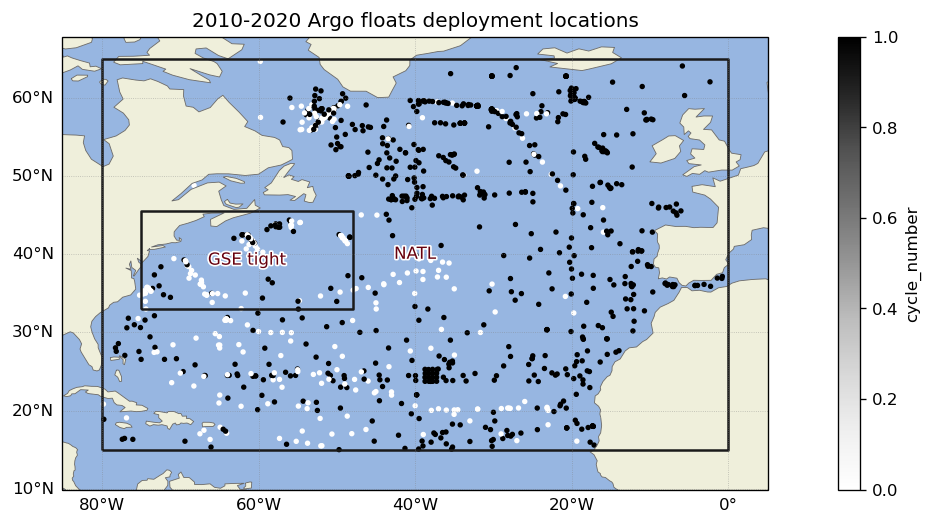

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)
regions.plot(ax=ax, add_land=True, add_ocean=True, label="abbrev", text_kws=text_kws)
dict_regions['NATL']['deployment'].plot(kind='scatter', x="longitude", y="latitude", c='cycle_number', ax=ax, marker='.')
argopy.plot.utils.latlongrid(ax)
ax.set_title('2010-2020 Argo floats deployment locations')

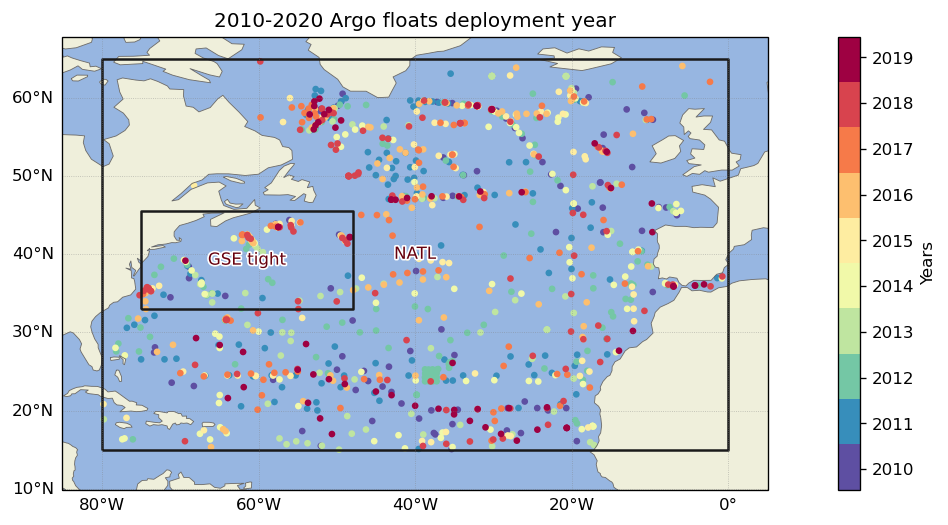

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)
regions.plot(ax=ax, add_land=True, add_ocean=True, label="abbrev", text_kws=text_kws)
census = dict_regions['NATL']['deployment'].set_index('date')
dc = argopy.plot.utils.discrete_coloring(name='Spectral_r', N=len(np.unique(census.index.year)))
sc = ax.scatter(x=census['longitude'], y=census["latitude"], c=census.index.year, marker='.', cmap=dc.cmap)
dc.cbar(ticklabels=np.unique(census.index.year), fraction=0.03, label='Years')
argopy.plot.utils.latlongrid(ax)
ax.set_title('2010-2020 Argo floats deployment year');

Text(0.5, 1.0, '2010-2020 annual Argo floats deployment count')

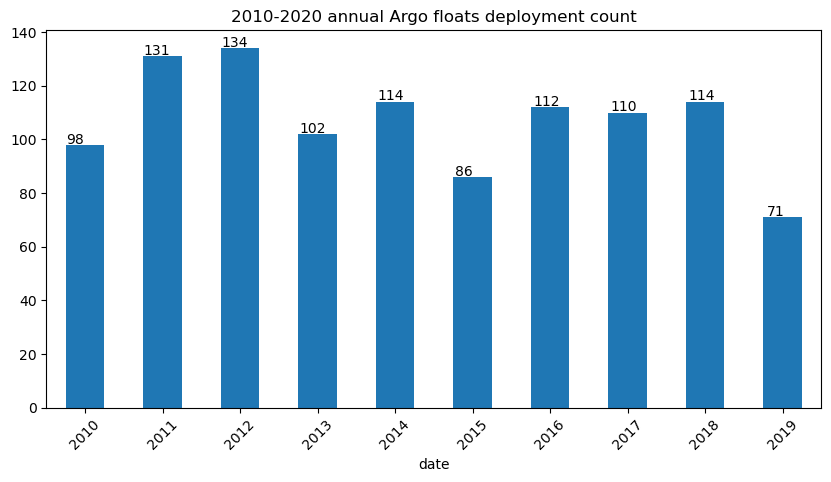

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), dpi=100, facecolor='w', edgecolor='k')
census = dict_regions['NATL']['deployment'].set_index('date').groupby(pd.Grouper(freq='Y'))['index'].count()
census.plot.bar(ax=ax)
[ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005)) for p in ax.patches] 
ax.set_xticklabels(census.index.year, rotation = 45)
ax.set_title('2010-2020 annual Argo floats deployment count')

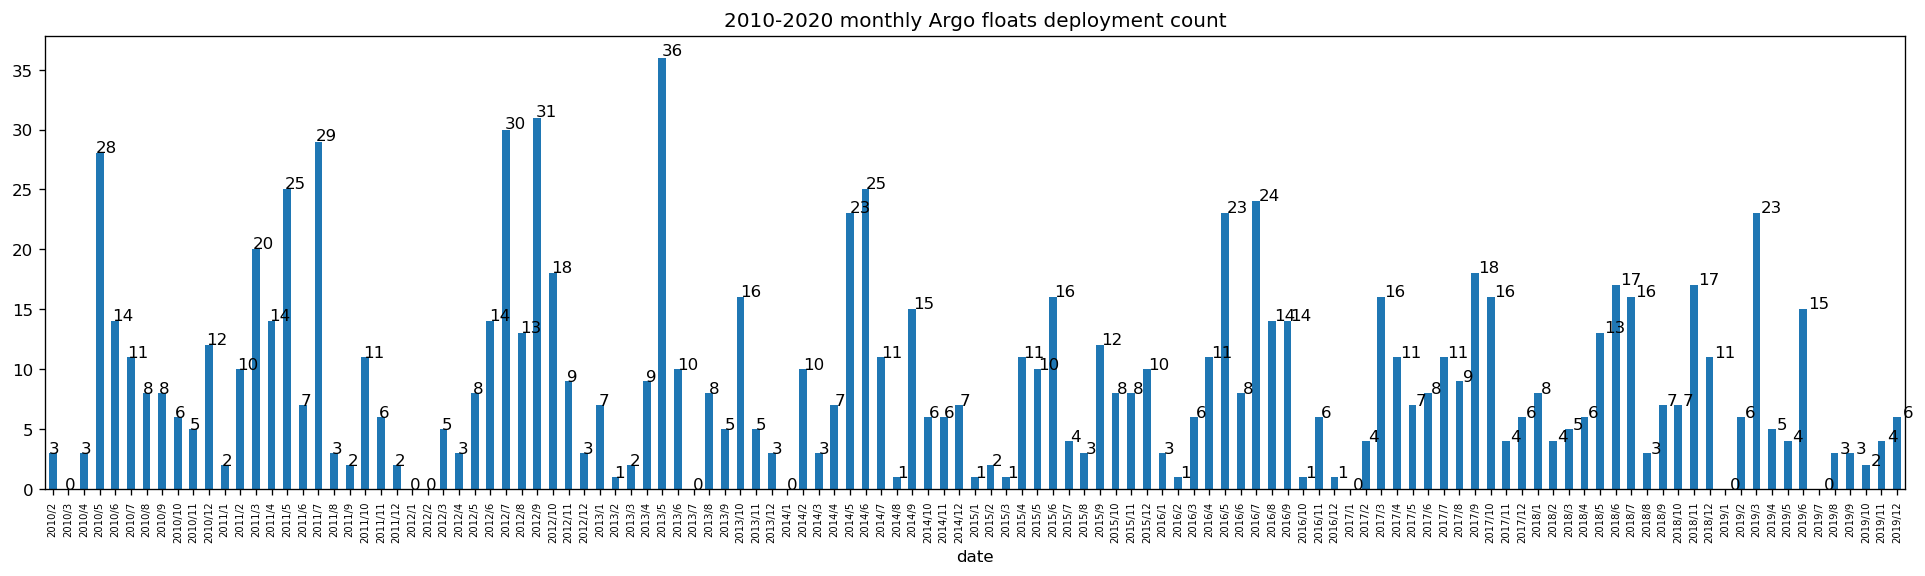

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,5), dpi=120, facecolor='w', edgecolor='k')
census = dict_regions['NATL']['deployment'].set_index('date').groupby(pd.Grouper(freq='M'))['index'].count()
census.plot.bar(ax=ax)
[ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005)) for p in ax.patches] 
ax.set_xticklabels(["%i/%i" % (i.year, i.month) for i in census.index], rotation = 90, fontsize=6)
ax.set_title('2010-2020 monthly Argo floats deployment count');

## Save for later re-use with VirtualFleet

What we need here is simply a list of latitude/longitude/date.  
So we just save the deployment pandas index into a json file, easy to read from anything.    
It will be easy to load it and extract latitude/longitude/date.  


In [17]:
out_file = '2010-2020-Deployment-Plan.json'
dict_regions['NATL']['deployment'].to_json(out_file, orient='records')

In [18]:
pd.read_json(out_file, orient='records')

,index,file,date,latitude,longitude,ocean,profiler_code,institution_code,date_update,wmo,institution,profiler,cycle_number,direction
0,73009,bodc/6900656/profiles/D6900656_001.nc,2010-02-12 11:47:13,55.307,-15.886,A,846,BO,1568323960000,6900656,"BODC, United Kingdom","Webb Research, Seabird sensor",1,A
1,73112,bodc/6900657/profiles/D6900657_001.nc,2010-02-14 02:02:55,53.579,-16.017,A,846,BO,1476238703000,6900657,"BODC, United Kingdom","Webb Research, Seabird sensor",1,A
2,72871,bodc/6900655/profiles/D6900655_001.nc,2010-02-23 07:02:57,51.158,-12.241,A,846,BO,1476236773000,6900655,"BODC, United Kingdom","Webb Research, Seabird sensor",1,A
3,159849,meds/4901139/profiles/D4901139_001.nc,2010-04-20 18:58:00,43.891,-57.824,A,846,ME,1488299333000,4901139,"MEDS, Canada","Webb Research, Seabird sensor",1,A
4,161044,meds/4901155/profiles/R4901155_001.nc,2010-04-20 23:56:00,43.528,-57.508,A,846,ME,1519138423000,4901155,"MEDS, Canada","Webb Research, Seabird sensor",1,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1067,155612,coriolis/7900561/profiles/D7900561_001.nc,2019-12-01 10:18:02,17.796,-20.612,A,846,IF,1616582510000,7900561,"Ifremer, France","Webb Research, Seabird sensor",1,A
1068,155592,coriolis/7900560/profiles/D7900560_001.nc,2019-12-01 10:58:14,17.790,-20.610,A,846,IF,1613743687000,7900560,"Ifremer, France","Webb Research, Seabird sensor",1,A
1069,171367,meds/4902499/profiles/D4902499_001.nc,2019-12-02 04:55:00,42.173,-48.324,A,844,ME,1637092031000,4902499,"MEDS, Canada","Arvor, Seabird conductivity sensor",1,A
1070,171364,meds/4902498/profiles/D4902498_001.nc,2019-12-02 04:55:00,42.210,-48.366,A,844,ME,1637336611000,4902498,"MEDS, Canada","Arvor, Seabird conductivity sensor",1,A


# Extract initial state on 2010-01-01

What we need here is the list of floats already deployed on 2010/1/1, the start of the Virtual Fleet simulation.  
These floats will contribute to the area sampling but are not included in the real deployment plan assembled above.  
From the VirtualFleet simulation point of view, the first profile of each of these floats reported after 2010/1/1, can be considered as a new particle, a new *deployment*.

The way to extract this information is to check all profiles reported in January 2010 with a cycle number larger than 1. This assumes that by the end of January, all floats will have re-surfaced and we won't miss any.


In [19]:
df = dict_regions['NATL']['index'][dict_regions['NATL']['index']['date']<pd.to_datetime('2010-02-01')].reset_index()
df = df[df['cycle_number']>1].reset_index(drop=True)
unique_shadow_wmo = np.unique(df['wmo'])
df = df.groupby('wmo').min()
df = df.drop(['file', 'date_update', 'direction', 'index', 'ocean'], axis=1).sort_values(by='date')
dict_regions['NATL']['deployment_shadow'] = df

In [20]:
# Make sure we're not considering a float that we already listed in the initial deployment plan:
dd = list(set(unique_shadow_wmo) - set(list(set(list(unique_wmo0) + list(unique_wmo1)))))
assert len(dd) == dict_regions['NATL']['deployment_shadow'].shape[0]

In [21]:
dict_regions['NATL']['deployment_shadow']

,date,latitude,longitude,profiler_code,institution_code,institution,profiler,cycle_number
wmo,,,,,,,,
6900243,2010-01-01 02:30:49,35.612,-19.170,846,IF,"Ifremer, France","Webb Research, Seabird sensor",134
4901132,2010-01-01 03:48:00,45.673,-34.012,846,ME,"MEDS, Canada","Webb Research, Seabird sensor",18
6900387,2010-01-01 04:01:02,56.910,-17.245,846,BO,"BODC, United Kingdom","Webb Research, Seabird sensor",156
6900493,2010-01-01 04:25:00,43.445,-19.621,841,IF,"Ifremer, France","Provor, Seabird conductivity sensor",56
6900630,2010-01-01 04:38:00,21.493,-28.450,841,IF,"Ifremer, France","Provor, Seabird conductivity sensor",97
...,...,...,...,...,...,...,...,...
4900360,2010-01-21 00:58:57,24.425,-62.976,851,AO,"AOML, USA","Solo, Seabird conductivity sensor",243
4900687,2010-01-21 11:07:03,39.803,-31.661,851,AO,"AOML, USA","Solo, Seabird conductivity sensor",158
4900370,2010-01-26 20:53:03,18.948,-75.038,851,AO,"AOML, USA","Solo, Seabird conductivity sensor",239


## Save for later re-use with VirtualFleet

In [22]:
out_file = '2010-2020-Deployment-Plan-Shadow.json'
dict_regions['NATL']['deployment_shadow'].to_json(out_file, orient='records')

# Compute effective 2010-2020 sampling

This is what we expect to reproduce for validation of the simulation and then to modify to improve BC sampling


In [60]:
# Compute profile density on a 1x1 degree grid:
ds = dict_regions['NATL']['index'].to_xarray()
xbins = np.arange(-90,10)
ybins = np.arange(10,70)
obs = histogram(ds['longitude'], ds['latitude'], bins=[xbins, ybins])
obs = obs.where(obs>0, other=np.NaN)

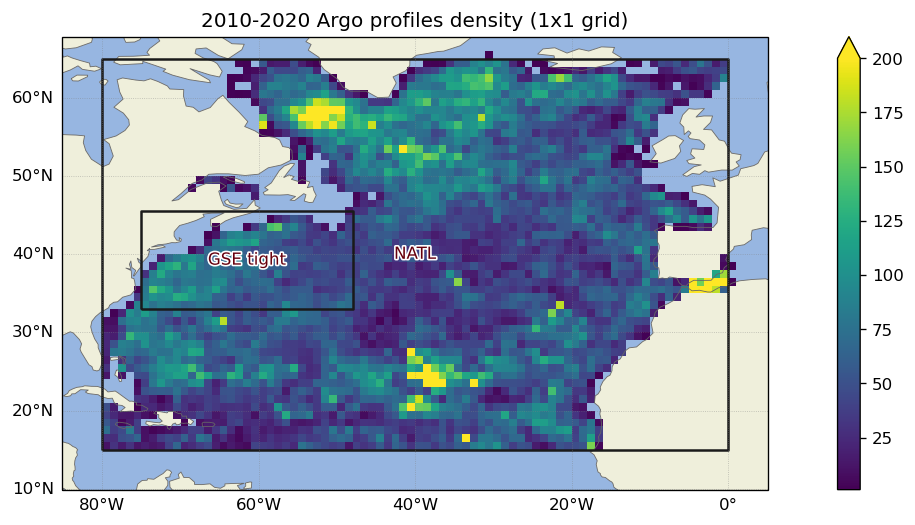

In [62]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)
regions.plot(ax=ax, add_land=True, add_ocean=True, label="abbrev", text_kws=text_kws)
argopy.plot.utils.latlongrid(ax)
cl = obs.plot(x='longitude_bin', vmin=1, vmax=200, add_colorbar=0)
plt.colorbar(cl, ax=ax, extend='max')
ax.set_title('2010-2020 Argo profiles density (1x1 grid)')
plt.savefig('2010-2010-Profile-Density.pdf', bbox_inches='tight', pad_inches=0.1)

In [84]:
ds.groupby('date.season').count()['file']

<xarray.DataArray 'file' (season: 4)>
array([40314, 43710, 42924, 44422])
Coordinates:
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'